In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Conv2D, Dropout, experimental, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory    
from tensorflow.keras.utils import plot_model 
import tensorflow as tf


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [79]:
import cv2
from imutils import paths

In [80]:
#load images 
datasetDir = 'PetImages'
imagePaths = list(paths.list_images(datasetDir))

In [81]:
#Generate dataset - split images into train and validation
image_size = (180,180)
batch_size = 32

train_ds = image_dataset_from_directory(datasetDir, 
                                        validation_split=0.2, 
                                        batch_size=batch_size, 
                                        image_size= image_size,  
                                        subset='training',
                                        seed=1337
                                       )
val_ds = image_dataset_from_directory(datasetDir, 
                                        validation_split=0.2, 
                                        batch_size=batch_size, 
                                        image_size= image_size,  
                                        subset='validation',
                                        seed=1337
                                       )

Found 1875 files belonging to 2 classes.
Using 1500 files for training.
Found 1875 files belonging to 2 classes.
Using 375 files for validation.


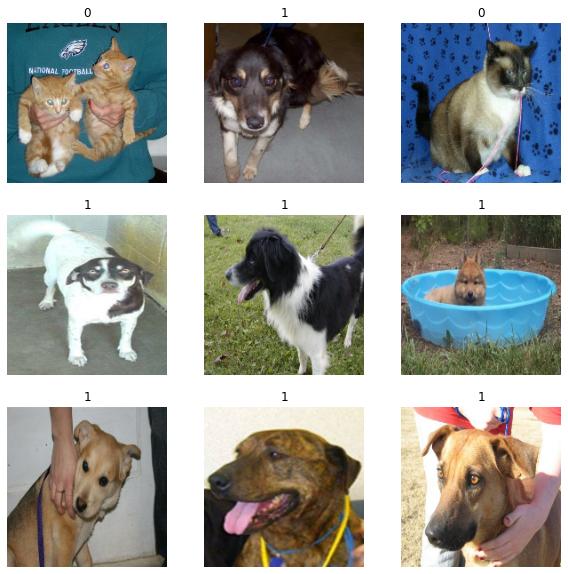

In [82]:
#Visualization data
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8')) 
        plt.title(int(labels[i]))
        plt.axis("off")

    

In [83]:
#image Data Augmentation
data_augmentation = Sequential(
    [
        experimental.preprocessing.RandomFlip("horizontal"),
        experimental.preprocessing.RandomRotation(0.1)
    ]
)

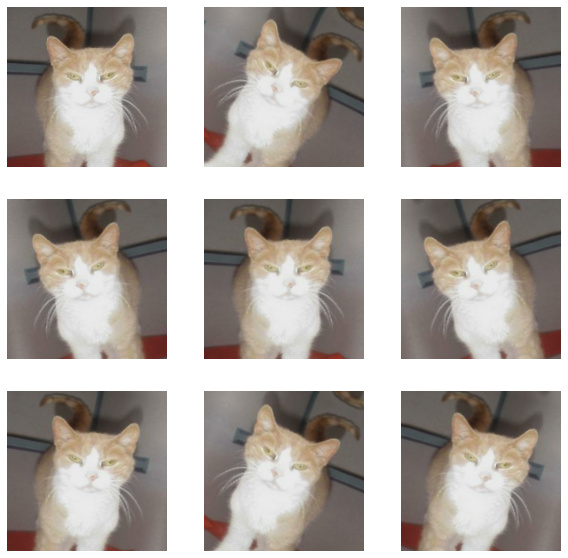

In [84]:
#Data Augmentationted Visualization  
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        aug_img = data_augmentation(images)
        plt.subplot(3,3,i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8')) 
        plt.axis("off")

In [85]:
#remove corrupted images
import os
delcount=0
for fname in imagePaths:
    try: 
        imgobj = open(fname, 'rb')
        is_jfif = tf.compat.as_bytes("JFIF") in imgobj.peek(10)
    finally:
        imgobj.close()
    if not is_jfif:
        delcount +=1
        os.remove(fname)
print("deleted image count "+str(delcount))

deleted image count 0


In [86]:
input_shape = image_size + (3,)
input_shape

(180, 180, 3)

In [93]:
# Build a Model 
model = Sequential()

model.add(experimental.preprocessing.Rescaling(1.0/255))
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape= input_shape, strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=5, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

for size in [128, 256, 512, 728]:
    model.add(Activation('relu'))
    model.add(SeparableConv2D(size, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Activation('relu'))
    model.add(SeparableConv2D(size, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(MaxPooling2D(3, strides=2, padding='same'))
    model.add(Conv2D(size, 1, strides=2, padding='same'))

model.add(SeparableConv2D(1024, 3, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Activation('relu'))


model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
#plot_model(model, show_shapes=True)

In [94]:
epochs = 20
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [96]:
trainmodel = model.fit(train_ds,epochs=epochs, validation_data=val_ds)

In [ ]:
model.save('cnn_doc_classification.f5')

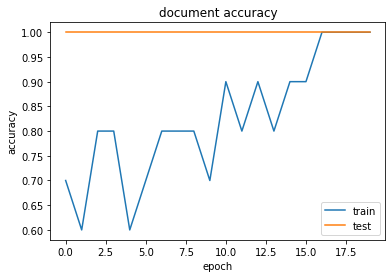

In [71]:
plt.plot(trainmodel.history['accuracy'])
plt.plot(trainmodel.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('document accuracy')
plt.legend(['train','test'])
plt.show()


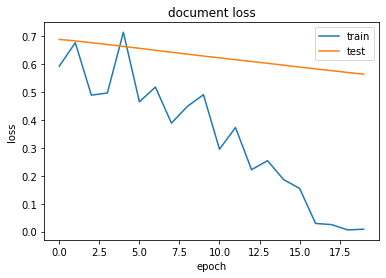

In [72]:
plt.plot(trainmodel.history['loss'])
plt.plot(trainmodel.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('document loss')
plt.legend(['train','test'])
plt.show()

In [74]:
testimg = 'test_images/test_dog1.jpg'
img = cv2.imread(testimg)
#plt.imshow(img.numpy().astype('uint8')) 
img = cv2.resize(img,(32,32))
img = (img / 255.).astype(np.float32)
print(img)

[[[0.34901962 0.48235294 0.47843137]
  [0.27058825 0.4392157  0.42745098]
  [0.28627452 0.46666667 0.45882353]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.2        0.39215687 0.36078432]
  [0.18431373 0.43529412 0.3882353 ]
  [0.2        0.43529412 0.39607844]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.16078432 0.32941177 0.28627452]
  [0.14117648 0.32156864 0.27058825]
  [0.16862746 0.34509805 0.28627452]
  ...
  [0.         0.02352941 0.01176471]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]]

 ...

 [[0.33333334 0.57254905 0.5176471 ]
  [0.43137255 0.6156863  0.5921569 ]
  [0.30588236 0.58431375 0.5568628 ]
  ...
  [0.28627452 0.52156866 0.4862745 ]
  [0.38039216 0.53333336 0.54509807]
  [0.24705882 0.46666667 0.43137255]]

 [[0.36078432 0.60784316 0.58431375]
  [0.42352942 0.62352943 0.5882353 ]


In [75]:
model.predict(np.array([img]))

array([[0.56880873]], dtype=float32)

In [76]:
np.argmax(model.predict(np.array([img])),axis=1)

array([0])